# Milestone 2 - Adavengers 2023

# Importing data

In [1]:
#Library Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.stats import diagnostic
import re
import gensim
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
metadata_headers = ["Wikipedia_ID", "Freebase_ID", "Movie_name" , "Release_date", "box_office_revenue", "runtime", "languages","countries", "genres"]
dfmetadata = pd.read_csv('data/movie.metadata.tsv',sep='\t',header =None, names =metadata_headers)
#dfmetadata.head()

#Reading in the Data
dfsummaries=pd.read_table('data/plot_summaries.txt',header=None,names=["Wikipedia_ID","Summary"])
#dfsummaries.head()
character_head = ["Wikipedia_ID","Freebase_ID", "Release_date", "Character_name", "Actor_date_of_birth", "Gender", "Height", "Ethnicity", "Actor_name", "Age","Freebase_character/actor_map_ID", "Freebase_character_ID", "Freebase_actor_ID"]
dfcharacter =pd.read_csv('data/character.metadata.tsv',sep='\t',header =None, names =character_head)

In this milestone, we will get acquainted with the data, preprocess it and do necessary descriptive statistics tasks. We will also plan our future analysis in detail and describe, as well as test, proposed methodologies.

# Cleaning Data

## 1) Cleaning Summaries Data

In [4]:
#Checking if the Wikipedia_IDs in summaries are the same as in Metadata by randomly checking an id (31186339)
print(dfsummaries[dfsummaries["Wikipedia_ID"]==31186339]["Summary"])
print(dfmetadata[dfmetadata["Wikipedia_ID"]==31186339]["Movie_name"]) 

1    The nation of Panem consists of a wealthy Capi...
Name: Summary, dtype: object
78373    The Hunger Games
Name: Movie_name, dtype: object


In [5]:
#Checking if there are NaNs
print(dfsummaries["Wikipedia_ID"].hasnans) #There are no NaNs.
print(dfsummaries["Summary"].hasnans) #There are no NaNs.

False
False


In [6]:
#Checking if there are double entries and removing them
print(dfsummaries["Wikipedia_ID"].is_unique) #This is true, nice!
print(dfsummaries["Summary"].is_unique) #This is false
dfsummaries.drop_duplicates(['Summary'],inplace=True)
print(dfsummaries["Summary"].is_unique) 
#Now we can see there are no more duplicates (remember to do same for metadata!)

True
False
True


In [7]:
#Another thing we could do is look at the type of the data. 
#The IDs should all be positive integers, the summaries all str.
dfsummaries.dtypes #We can see that this is the case

Wikipedia_ID     int64
Summary         object
dtype: object

In [8]:
#Checking if we have negative values for ID
dfsummaries["Wikipedia_ID"].min() #Nice! They're all positive.

330

In [9]:
#Checking how many entries there are
print("number of summary entries:",len(dfsummaries))
print("number of metadata entries:",len(dfmetadata)) 
#We can see that there is not a summary for every movie but only about half.

number of summary entries: 42295
number of metadata entries: 81741


In [10]:
#Check the lengths of the summaries (we can see that there is a great spread.)
dfsummaries["Summary_Length"]=dfsummaries['Summary'].apply(lambda x: len(x))
print("The length of summaries ranges from %d to %d characters." %(dfsummaries["Summary_Length"].min(),dfsummaries["Summary_Length"].max()))

The length of summaries ranges from 99 to 28159 characters.


Text(0.5, 0, 'Summary length in characters')

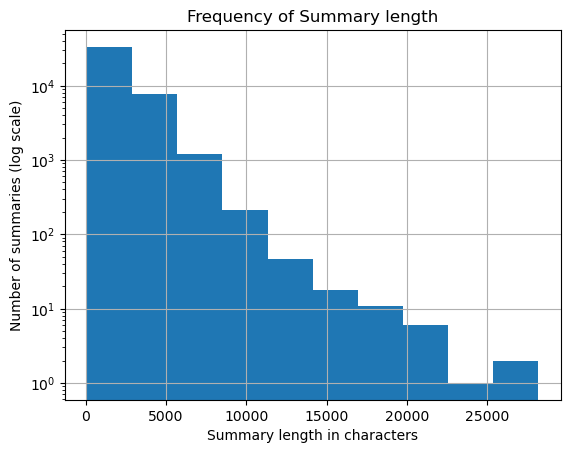

In [11]:
#Displayed in a logarithmic histogram, we can see that most movie summaries are short and a few are bigger.
dfsummaries["Summary_Length"].hist(log=True)
plt.title("Frequency of Summary length")
plt.ylabel("Number of summaries (log scale)")
plt.xlabel("Summary length in characters")

In [12]:
#So, how are the summary lengths actually distributed? Let's find out
print(diagnostic.kstest_normal(dfsummaries['Summary_Length'].values, dist = 'norm'))
print(diagnostic.kstest_normal(dfsummaries['Summary_Length'].values, dist = 'exp'))
#P-avlue < 0.05. The summary lengths are neither normal nor exponentially dist

(0.17600314066454867, 0.0009999999999998899)
(0.0571594944628687, 0.0009999999999998899)


There are some summaries much longer than others. Though for now we do the learning on the whole summary dataset as if it was a huge text. This might lead to a bias that the word embedding will learn more from movies with a bigger summary length than those with a shorter. An hypothesis we have is that maybe the longest summaries are the most watched movies and thus the most representative of how the bias between men and women might be seen by the general public of people watching movies. To check this let's do a scatter plot with box office thinking that movies with most data are the most watched movies.

## 2 Cleaning Metadata

In [13]:
dfmetadata.head()

,Wikipedia_ID,Freebase_ID,Movie_name,Release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


#### Duplicates and NaNs

In [14]:
#Checking for duplicates
dfmetadata["Wikipedia_ID"].is_unique
dfmetadata["Freebase_ID"].is_unique

True

In [15]:
#Checking for NaNs using the Non-Null Count
dfmetadata.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Wikipedia_ID        81741 non-null  int64  
 1   Freebase_ID         81741 non-null  object 
 2   Movie_name          81741 non-null  object 
 3   Release_date        74839 non-null  object 
 4   box_office_revenue  8401 non-null   float64
 5   runtime             61291 non-null  float64
 6   languages           81741 non-null  object 
 7   countries           81741 non-null  object 
 8   genres              81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


In [16]:
(len(dfmetadata)-dfmetadata["box_office_revenue"].isna().sum()) /len(dfmetadata)
#We can see that we only have box office revenue values for around 10% of the movie data!

0.1027758407653442

We can see that there are some NaNs for the release date and the runtime. Especially, there seem to be alot of NaNs for box office revenue!
This is important as it might affect the feasibility of answering the question if the amount of women in a movie has an effect on box office revenue. We kept the research question in our proposal as an additional question to maybe explore in the end if we have the time. In that case we would also consider incorporating additional data.

#### Release Dates

We can see that the release Dates are sometimes written in a date format 2000-02-16 and sometimes it is just the year. In order to have uniform dates, we choose only the year. Since we are looking at longer timespans, we think the year is more important than the date

In [17]:
def only_year(date):
    date = str(date)
    if len(date) == 4:
        return date
    else:
        return date[:4]
    date=int(date)

# Apply the function to standardize dates
dfmetadata['test'] = dfmetadata['Release_date'].apply(only_year)

dfmetadata

,Wikipedia_ID,Freebase_ID,Movie_name,Release_date,box_office_revenue,runtime,languages,countries,genres,test
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983
...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992


Text(0.5, 1.0, 'runtime of movies')

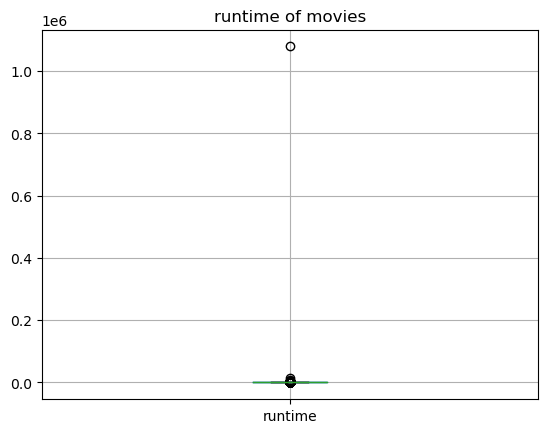

In [18]:
dfmetadata.boxplot(column= "runtime")
plt.title("runtime of movies")

There are some extreme values. A film 8000 minutes long must be quite boring. Let's look at those data.

In [19]:
dfmetadata.loc[dfmetadata["runtime"]>8000,:]

,Wikipedia_ID,Freebase_ID,Movie_name,Release_date,box_office_revenue,runtime,languages,countries,genres,test
12804,10815585,/m/02qqy23,Zero Tolerance,1995,NaN,1079281.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",1995
62962,32441022,/m/0gyr803,Modern Times Forever,NaN,NaN,14400.0,{},{},"{""/m/0jtdp"": ""Documentary""}",nan
71100,25345684,/m/09gqhh3,Cinématon,2011,NaN,9360.0,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France""}","{""/m/0424mc"": ""Experimental film"", ""/m/0jtdp"":...",2011


After a quick look on internet (https://en.wikipedia.org/wiki/Zero_Tolerance_(1994_film)) we noticed that the runtime of the longer movie is actually of 94 minutes which is much shorter than the indicated runtime we thus replace the abberant value. For the other high values we just change them to Nan.

In [20]:
dfmetadata.loc[12804, ["runtime"]] =  94
#We subjectively decide that a movie longer than 10 hours is to long and it's an error in the data
dfmetadata.loc[dfmetadata["runtime"]>600,:] = np.NaN

Text(0, 0.5, 'Runtime in minutes')

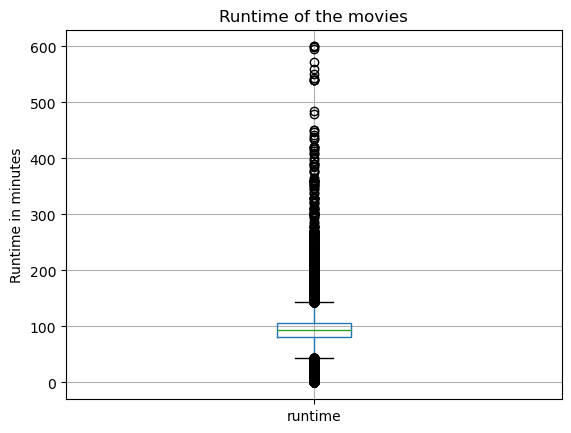

In [21]:
dfmetadata.boxplot(column= "runtime")
plt.title("Runtime of the movies")
plt.ylabel("Runtime in minutes")

## 3) Cleaning character data

First let's have a quick look at the data.

In [22]:
dfcharacter 

,Wikipedia_ID,Freebase_ID,Release_date,Character_name,Actor_date_of_birth,Gender,Height,Ethnicity,Actor_name,Age,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


In [23]:
dfcharacter.describe()

,Wikipedia_ID,Height,Age
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


#### Height
We see that the maximum height is 510 which doesn't make sense. We look at the characters with a height above 2m75 as it is the height of the tallest person registered on the guinness world records.

In [24]:
display(dfcharacter[dfcharacter.Height>2.75])

,Wikipedia_ID,Freebase_ID,Release_date,Character_name,Actor_date_of_birth,Gender,Height,Ethnicity,Actor_name,Age,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
21619,1291587,/m/04qk12,2004-09-01,young Georgie,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,18.0,/m/0k276dx,/m/0k276dz,/m/0bggwvl
49659,30865068,/m/02ml14,1998-10-15,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0n9ld0y,NaN,/m/08hqh0
59719,12206655,/m/02vvw24,NaN,Dominic,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,NaN,/m/0k276dq,/m/0h8hcr1,/m/0bggwvl
104140,17999628,/m/047n_2q,1998,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0cg31bd,NaN,/m/08hqh0
205679,1373475,/m/04xmx8,2003-08-15,Jackal Johnson,1972-12-06,M,510.0,NaN,Vince Corazza,30.0,/m/02vbm0k,/m/0h60xk7,/m/08hqh0
219383,179326,/m/018gq3,1996-11-18,Herbert,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,10.0,/m/0bggwv8,/m/0bggwvc,/m/0bggwvl
301653,4667507,/m/0cg9n6,2001-11-29,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,28.0,/m/0cg0zwp,NaN,/m/08hqh0
316621,3915041,/m/0b6lyp,2002,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,29.0,/m/02vc5p5,NaN,/m/08hqh0
341890,29290087,/m/0b3w9mr,1997-04-07,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,24.0,/m/0gvwy8x,NaN,/m/08hqh0
360967,14413223,/m/03d2rnl,2012-04-20,Young Punk Guy,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,26.0,/m/0m4q87d,/m/0k9tfs8,/m/0bggwvl


We notice that most values for height are in meters and somes are in centimeters and some are of 510. However there are only 15 outliers above 2.75 which are mostly the same actors. We considered changing Zohren Weiss height to 1m80 but as we don't find on internet there true height to check if it was this we are just going to remove it. Moreover we probably won't use Height so we just change the values to Nan.

In [25]:
dfcharacter.loc[:,["Height"]] = dfcharacter.loc[:,["Height"]].mask(dfcharacter["Height"] >2.75)
dfcharacter.Height.describe()

count    154809.000000
mean          1.748177
std           0.106249
min           0.610000
25%           1.676400
50%           1.750000
75%           1.830000
max           2.356000
Name: Height, dtype: float64

#### Age 

We notice negative age which doesn't make sense. When we check on the imbd it correspond to error in the birth date entry thus we transform the age and the birth date to Nan when negative values are found.

In [26]:
dfcharacter.loc[:,["Age","Actor_date_of_birth"]] = dfcharacter.loc[:,["Age","Actor_date_of_birth"]].mask(dfcharacter["Age"] <0)
dfcharacter.Age.describe()

count    292175.000000
mean         37.890901
std          14.085909
min           0.000000
25%          28.000000
50%          36.000000
75%          47.000000
max         103.000000
Name: Age, dtype: float64

The minimum age is now at 0 which corresponds to baby born this year so we are happy. Let's now groupby gender to check whether there are differences between the genders in the data that can be cofounders in our analysis.

#### Difference between genders

In [27]:
Grouped_gender = dfcharacter.groupby("Gender")
Grouped_gender.Age.describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
F,99124.0,32.956055,13.376106,0.0,24.0,30.0,40.0,99.0
M,191277.0,40.469717,13.749781,0.0,31.0,39.0,49.0,103.0


Text(0, 0.5, 'Age in years')

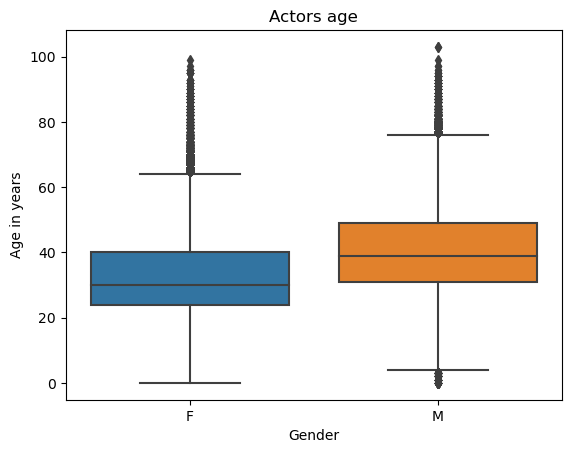

In [28]:
sns.boxplot(data =dfcharacter, x = "Gender", y = "Age" )
plt.title("Actors age")
plt.ylabel("Age in years")

We observe a difference between male and female age let's see if it's statistically significant.

In [29]:
ttest_ind( dfcharacter.loc[dfcharacter['Gender'] == "M", 'Age'].dropna(),dfcharacter.loc[dfcharacter['Gender'] == "F", 'Age'].dropna())

Ttest_indResult(statistic=140.92509242040052, pvalue=0.0)

The p-value is lower than 0.05 thus we can reject the null hypothesis that the two distributions have the same mean. The statistics is positive thus we can say than in average man actors are older than women. This is a well known fact but it is always interesting to observe that women actress are in average younger than man actors. Moreover we need to keep this information in mind when we analyze the adjectives as women are younger than men in average because younger people can be described with different adjectives than older people.

## 4) Describing Summaries and Movie Metadata

In [132]:
movie_merged = dfmetadata.merge(dfsummaries,how ='outer')
movie_merged["summary_presence"] = (~movie_merged["Summary"].isna()).astype(int)

Let's see if the dataset with summaries is representative of the actual movie dataset.

Text(0.5, 0, 'Presence of summary')

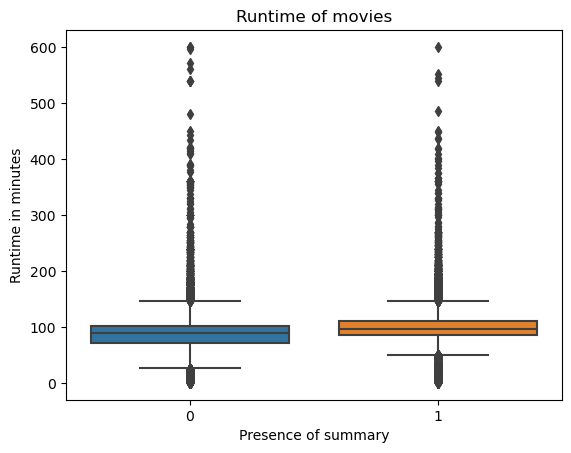

In [31]:
sns.boxplot(data =movie_merged, x = "summary_presence", y = "runtime" )
plt.title("Runtime of movies")
plt.ylabel("Runtime in minutes")
plt.xlabel("Presence of summary")

We notice that there are very short movies. Let's see if the runtime of a movie as an influence on the summary length to be sure the model doesn't train to much short movies that aren't necessarely representative of the watched movies by the public.

In [136]:
runtime_and_summary_length = movie_merged[(~movie_merged['Summary_Length'].isna()) & (~movie_merged['runtime'].isna())]
len(runtime_and_summary_length)

35563

Text(0.5, 1.0, 'Runtime in function of summary length')

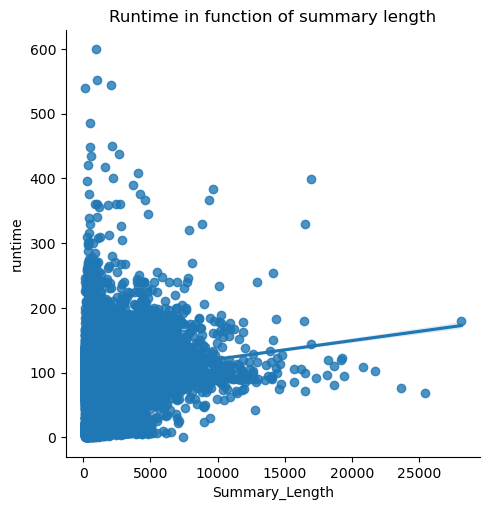

In [33]:
sns.lmplot(data = runtime_and_summary_length, x= "Summary_Length", y = "runtime")
plt.title("Runtime in function of summary length")

Text(0.5, 1.0, 'Runtime in function of summary length')

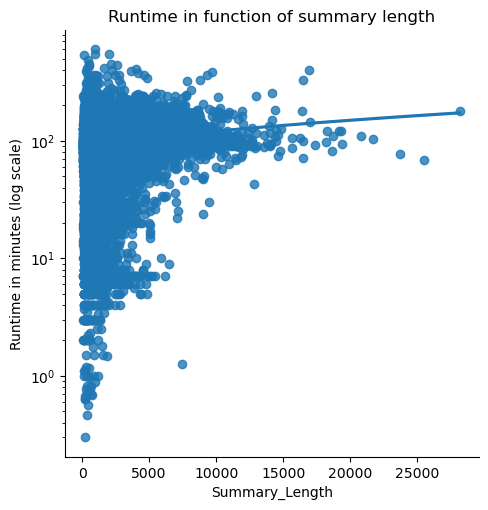

In [34]:
sns.lmplot(data = runtime_and_summary_length, x= "Summary_Length", y = "runtime")
plt.yscale("log") 
plt.ylabel("Runtime in minutes (log scale)")
plt.title("Runtime in function of summary length")

In [35]:
print(stats.pearsonr(runtime_and_summary_length['Summary_Length'],runtime_and_summary_length['runtime']))

PearsonRResult(statistic=0.16021729056698988, pvalue=4.1017517089482376e-203)


 When we look at the pearson correlation we observe a small positive correlation which is what was expected. The runtime actually has an effect on the summary length.The longest movies have longer summaries and thus bigger impact on our model which is normal.
The runtime anyway is not statiscally different between movies containing a summary and movies that don't thus the dataset with summaries is representative of the total dataset in runtime period. 

In [36]:
ttest_ind(movie_merged.loc[movie_merged['summary_presence'] == 1, 'runtime'].dropna(),movie_merged.loc[movie_merged['summary_presence'] == 0, 'runtime'].dropna())


Ttest_indResult(statistic=38.6787260170193, pvalue=0.0)

The p-value is lower than 0.5 thus we can exclude the null hypothesis that the movie with a summary and the movies without follow the same distribution for runtime. The statistic is positive meaning the movies which contains a summary have a longer runtime which is expected. However the dataset with summaries is thus not representative of the general dataset for runtime. As we consider longer film to be more watched we won't try to adapt the data but must keep this in mind. 

#### Box office revenue analysis

Let's look if the movies with summary are representative of the movies the most watched. By looking at the box office revenue.
The longer the summary the more the training will be done on it. Thus we want to check if longers summaries are more watched.

Text(0.5, 0, 'Presence of summary')

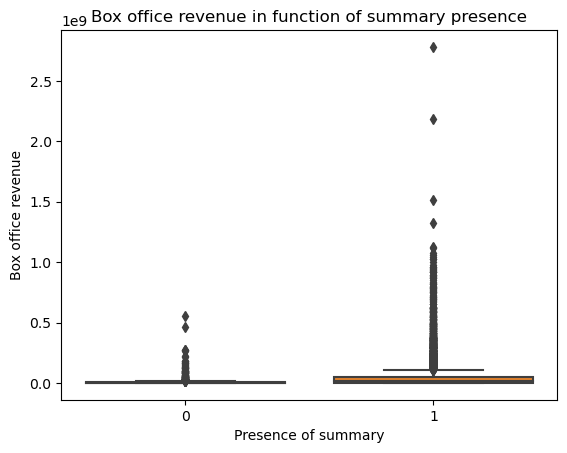

In [37]:
sns.boxplot(data =movie_merged, x = "summary_presence", y = "box_office_revenue" )
plt.title("Box office revenue in function of summary presence")
plt.ylabel("Box office revenue")
plt.xlabel("Presence of summary")

We notice that there are much more movies when summaries are in the dataset. Furthermore the the box office revenue is mainly higher for movies with a summary. Let's see if it's statistically significant.

In [38]:
ttest_ind(movie_merged.loc[movie_merged['summary_presence'] == 1, 'box_office_revenue'].dropna(),movie_merged.loc[movie_merged['summary_presence'] == 0, 'box_office_revenue'].dropna())

Ttest_indResult(statistic=9.444435849095447, pvalue=4.544470664944394e-21)

The p-value is lower than 0.5 thus we can exclude the null hypothesis that the movie with a summary and the movies without follow the same distribution for box-office revenue. The movie with a summary have in average bigger box-office which is great news because it means they are more watched

In [39]:
box_office_and_summary_length = movie_merged[(~movie_merged['Summary_Length'].isna()) & (~movie_merged['box_office_revenue'].isna())]
print(f'There are {len(box_office_and_summary_length)} movies which contain values for the summary and the box office revenue')
                    

There are 7586 movies which contain values for the summary and the box office revenue


Text(0.5, 29.140624999999986, 'Summary length in characters')

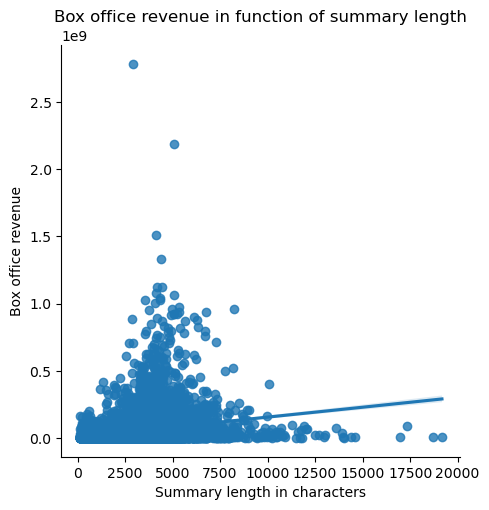

In [40]:
sns.lmplot(data = box_office_and_summary_length, x= "Summary_Length", y = "box_office_revenue")
plt.title("Box office revenue in function of summary length")
plt.ylabel("Box office revenue")
plt.xlabel("Summary length in characters")

There are some very big values for box office we can use log scale to have a better visualisation of the data for smaller box office.

Text(0.5, 29.140624999999986, 'Summary length in characters')

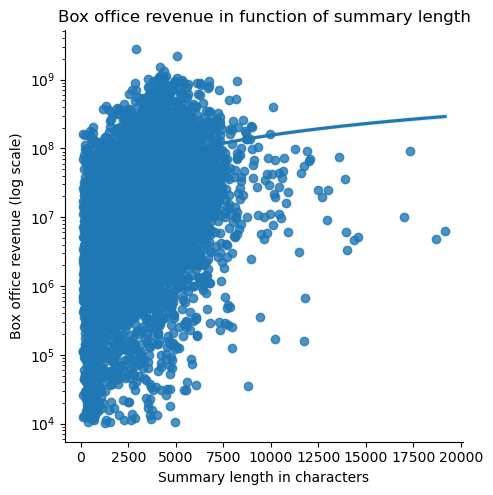

In [41]:
sns.lmplot(data = box_office_and_summary_length, x= "Summary_Length", y = "box_office_revenue")
plt.yscale("log") 
plt.title("Box office revenue in function of summary length")
plt.ylabel("Box office revenue (log scale)")
plt.xlabel("Summary length in characters")

In [42]:
print(stats.pearsonr(box_office_and_summary_length['Summary_Length'],box_office_and_summary_length['box_office_revenue']))

PearsonRResult(statistic=0.2513657107024293, pvalue=1.1821237120694585e-109)


There is a small positive correlation between box office revenue and the summary length. Which is good news because the longer the summary the more our algorithm will train on it. However there are huge differences between the length of our summaries which might be lead to bias in the learning. To resolve this we can do a weighted learning and give less weigth to the movies with big summaries but this has not yet been implemented. Box office revenues are a good indication of how much a movie is watched thus of how influent it is on the general public. 

In [43]:
summary_and_movie = dfmetadata.merge(dfsummaries,how ='right')

## 5) Summary and character cleaning

We want to look if the movies with summaries are the ones which also have characters

In [44]:
print(f'There are {len(summary_and_movie)} movies that have summary data')
nb_sumarry_and_character = len(summary_and_movie[summary_and_movie["Freebase_ID"].isin(dfcharacter["Freebase_ID"])])
print(f'There are {nb_sumarry_and_character} movies which contain data for characters and summary' )

There are 42295 movies that have summary data
There are 37763 movies which contain data for characters and summary


However when we look at it in detail some of the character data don't have character_name in it as we will need this data it might be an issue if we don't have enough data and we might need to rethink our strategy for detecting the gender of characters. To replace it by he or she.

In [149]:
dfcharacter_in_summary = dfcharacter[dfcharacter["Freebase_ID"].isin(summary_and_movie["Freebase_ID"])]
print(f'There are {len(dfcharacter_in_summary)} characters in movies that also have a summary')
character_with_name = dfcharacter_in_summary[~dfcharacter_in_summary["Character_name"].isna()]
print(f'There are {len(character_with_name)} characters with a name in movies that also have a summary')
print(f'There is {len(character_with_name)/len(dfcharacter)} percent of characters of which we can use the names')

There are 308367 characters in movies that also have a summary
There are 142353 characters with a name in movies that also have a summary
There is 0.31587040599641864 percent of characters of which we can use the names


,Wikipedia_ID,Freebase_ID,Release_date,Character_name,Actor_date_of_birth,Gender,Height,Ethnicity,Actor_name,Age,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450661,913762,/m/03pcrp,1992-05-21,UN Spacy Commander,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr407w,/m/0kr407_,/m/0gn4bz
450662,913762,/m/03pcrp,1992-05-21,Silvie Gena,1958,F,NaN,NaN,Susan Byrkett,34.0,/m/0kr40b9,/m/0kr40bf,/m/0gn4nd
450663,913762,/m/03pcrp,1992-05-21,Exegran,NaN,M,NaN,NaN,Hal Cleaveland,NaN,/m/0kr407c,/m/0kr406_,/m/0kr407h
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv


In [137]:
movie_with_char_names = len(summary_and_movie[summary_and_movie["Freebase_ID"].isin(character_with_name["Freebase_ID"])])
print(f'{movie_with_char_names} movies have data for character name')
print(f'{movie_with_char_names/len(dfmetadata)} percent of the movie have data about the character names')

23059 movies have data for character name
0.2820983349848913 percent of the movie have data about the character names


,Wikipedia_ID,Freebase_ID,Movie_name,Release_date,box_office_revenue,runtime,languages,countries,genres,test,Summary,Summary_Length
0,23890098.0,/m/076w2lb,Taxi Blues,1990-09-07,NaN,110.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/0f8l9c"": ""France"", ""/m/05vz3zq"": ""Soviet ...","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...",1990,"Shlykov, a hard-working taxi driver and Lyosha...",178
1,31186339.0,/m/0gkz15s,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",2012,The nation of Panem consists of a wealthy Capi...,4559
2,20663735.0,/m/051zjwb,Narasimham,2000,NaN,175.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...",2000,Poovalli Induchoodan is sentenced for six yea...,3101
3,2231378.0,/m/06xtz3,The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",1951,"The Lemon Drop Kid , a New York City swindler,...",4917
4,595909.0,/m/02tqm5,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,Seventh-day Adventist Church pastor Michael Ch...,2425
...,...,...,...,...,...,...,...,...,...,...,...,...
42290,34808485.0,/m/0j3dcl6,Oomakkuyil Padumbol,2012-02-17,NaN,NaN,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/0bj8m2"": ""Children's""}",2012,"The story is about Reema , a young Muslim scho...",220
42291,1096473.0,/m/045pct,The Last Command,1928,NaN,88.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...",1928,"In 1928 Hollywood, director Leo Andreyev look...",2971
42292,35102018.0,/m/0j6777g,Randy Parsons: American Luthier,2011-10-04,NaN,8.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/04rlf"": ""Music...",2011,American Luthier focuses on Randy Parsons’ tra...,871
42293,8628195.0,/m/04f7jfs,Kabuliwala,1961-12-14,NaN,134.0,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama""}",1961,"Abdur Rehman Khan , a middle-aged dry fruit se...",1289


This is not a lot of movies but we will anyway proceed with the analysis on this data. We decided it should be enough to work on. If however we realize later in the project that we are too short on data for the learning to be significant we will try to extract it on imbd.

## 6) Cleaning cluster data

In this step, we want to begin the initial investigations for the research question which character types women usually play. 

In [47]:
#We can see that the infos about character, movie, id and actor are all in one column.
df_clusters_initial=pd.read_table('data/tvtropes.clusters.txt',header=None)
df_clusters_initial

,0,1
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."
...,...,...
496,young_gun,"{""char"": ""Morgan Earp"", ""movie"": ""Tombstone"", ..."
497,young_gun,"{""char"": ""Colorado Ryan"", ""movie"": ""Rio Bravo""..."
498,young_gun,"{""char"": ""Tom Sawyer"", ""movie"": ""The League of..."
499,young_gun,"{""char"": ""William H. 'Billy the Kid' Bonney"", ..."


In [48]:
#The infos are stored in string representations of dictionaries
example_entry = df_clusters_initial[1][1]
print(type(example_entry))

<class 'str'>


In [49]:
#We need to turn the string representations of dictionaries into actual dictionaries
#(The if statement is just so the cell can be run without having run the previous cells, to avoid confusion)
import ast
if type(example_entry)==str: 
    df_clusters_initial[1]=df_clusters_initial[1].apply(lambda x: ast.literal_eval(x))

In [50]:
#Now, we can separate the values in the dictionaries to different columns
df_dict = pd.json_normalize(df_clusters_initial[1])

In [51]:
#Adding the separated dictionary values to the initial df
dfclusters = pd.concat([df_clusters_initial.drop(1,axis=1), df_dict], axis=1)

In [52]:
dfclusters=dfclusters.rename(columns={0:"type",'actor':'Actor_name','id':'Freebase_character/actor_map_ID'})
dfclusters

,type,char,movie,Freebase_character/actor_map_ID,Actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
...,...,...,...,...,...
496,young_gun,Morgan Earp,Tombstone,/m/0k776f,Bill Paxton
497,young_gun,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson
498,young_gun,Tom Sawyer,The League of Extraordinary Gentlemen,/m/0k5nsh,Shane West
499,young_gun,William H. 'Billy the Kid' Bonney,Young Guns II,/m/03lrjk0,Emilio Estevez


In [53]:
#Checking if there are NaN values:
print(dfclusters['type'].hasnans)
print(dfclusters['char'].hasnans)
print(dfclusters['movie'].hasnans)
print(dfclusters['Freebase_character/actor_map_ID'].hasnans)
print(dfclusters['Actor_name'].hasnans)

False
False
False
False
False


In order to see which character types are more commonly females and which males we have to merge this with the character metadata dataframe

In [148]:
#We only need the info on genders from the character df so I do this to avoid having to drop many columns later
clusters_merged = dfclusters.merge(dfcharacter[['Freebase_character/actor_map_ID', 'Gender']],on="Freebase_character/actor_map_ID")


In [55]:
#grouping by type and gender
types = clusters_merged.groupby(['type', 'Gender']).size().unstack(fill_value=0)

#adding a column for total M+F to see which types are most comon
types['total_count'] = types['F'] + types['M']

#adding a column for the percentage of women
types['F_percentage'] = (types['F'] / (types['F'] + types['M']))*100

# Resetting index to make 'type' a column
types.reset_index(inplace=True)

In [56]:
types.sort_values(by='F_percentage',ascending=False).head(15)

Gender,type,F,M,total_count,F_percentage
44,junkie_prophet,2,0,2,100.000000
12,chanteuse,6,0,6,100.000000
51,ophelia,5,0,5,100.000000
34,final_girl,6,0,6,100.000000
15,classy_cat_burglar,1,0,1,100.000000
53,prima_donna,6,0,6,100.000000
69,valley_girl,6,0,6,100.000000
27,dumb_blonde,10,1,11,90.909091
6,broken_bird,4,1,5,80.000000
5,brainless_beauty,7,5,12,58.333333


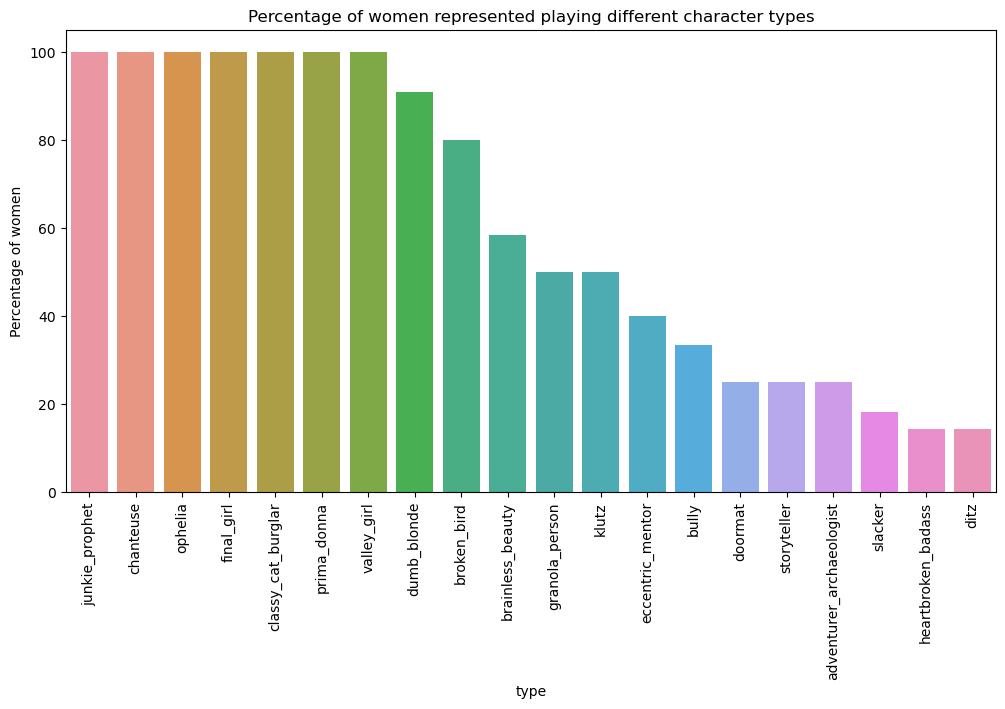

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6)) 
ax = sns.barplot(x='type',y="F_percentage", data=types.sort_values(ascending=False,by='F_percentage').head(20))
ax = plt.title("Percentage of women represented playing different character types")
ax = plt.ylabel("Percentage of women")
ax = plt.xticks(rotation=90) 

We can see that women are most represented in character types such as "valley girl" or "prima donna", and less in types such as "adventurer archaeologist". However, it is important to note that the clusters data is very short, so this is not very meaningful. Nevertheless, we thought it was interesting to see. Maybe in future analyses we can expand on the different character types or create our own. 

Next, we want to see if the effect of character types on gender they are played by is significant. Since gender is binary (F/M) and character types is categorical, we performed a chi square test:

In [58]:
#Doing a chi squared test

#Creating contingency table
contingency_table = pd.crosstab(clusters_merged['Gender'], clusters_merged['type'])

#Performing chi squared test
chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p_value}")

Chi-squared statistic: 369.8513527525936
P-value: 5.592160386860096e-42


We can see that the gender difference when playing different character types is very significant! P-value 5.59e-42 (<<0.05). However, as noted before, the dataset for character types is very small, so this result needs to be taken with a grain of salt.

## 7) Women in different movie genres

Analoug to the previous step, where we started to investigate which character types female actrices usually play, in this step, we start the analysis for the research question how female characters are represented in different movie genres. 

In [147]:
#In order to investigate women in different genres, we need to merge the metadata and character data.
meta_char_merged=dfcharacter[['Freebase_ID','Actor_name','Gender']].merge(dfmetadata[['Freebase_ID','Movie_name','genres']],on="Freebase_ID")

#Like with the character types in the cluster data, the can see that the genres in the movie metadata are stored string representing a dictionary. We therefore need to change the string representation to dictionary and then create different columns for the genres.

In [138]:
example_entry1 = meta_char_merged.genres[1]
print(type(example_entry1))
print(example_entry1)

<class 'dict'>
{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science Fiction', '/m/03npn': 'Horror', '/m/03k9fj': 'Adventure', '/m/0fdjb': 'Supernatural', '/m/02kdv5l': 'Action', '/m/09zvmj': 'Space western'}


,Freebase_ID,Actor_name,Gender,Movie_name,genres
0,/m/03vyhn,Wanda De Jesus,F,Ghosts of Mars,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
1,/m/03vyhn,Natasha Henstridge,F,Ghosts of Mars,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
2,/m/03vyhn,Ice Cube,M,Ghosts of Mars,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
3,/m/03vyhn,Jason Statham,M,Ghosts of Mars,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
4,/m/03vyhn,Clea DuVall,F,Ghosts of Mars,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
...,...,...,...,...,...
450511,/m/03pcrp,Dorothy Elias-Fahn,F,The Super Dimension Fortress Macross II: Lover...,"{'/m/06n90': 'Science Fiction', '/m/0gw5n2f': ..."
450512,/m/03pcrp,Jonathan Fahn,M,The Super Dimension Fortress Macross II: Lover...,"{'/m/06n90': 'Science Fiction', '/m/0gw5n2f': ..."
450513,/m/0cp05t9,David Hemmings,M,Five Clues to Fortune,{'/m/0lsxr': 'Crime Fiction'}
450514,/m/0cp05t9,Roberta Paterson,NaN,Five Clues to Fortune,{'/m/0lsxr': 'Crime Fiction'}


In [61]:
#First, we need to change the type from a string representation to a dictionary
if type(example_entry1)==str: 
    meta_char_merged.genres=meta_char_merged.genres.apply(lambda x: ast.literal_eval(x))

#Now, we can create a df where the genres are all in different columns
df_dict1 = pd.json_normalize(meta_char_merged.genres)

In [62]:
df_dict1.head()

,/m/01jfsb,/m/06n90,/m/03npn,/m/03k9fj,/m/0fdjb,/m/02kdv5l,/m/09zvmj,/m/02n4kr,/m/03bxz7,/m/07s9rl0,...,/m/0bbctgg,/m/0hj3myj,/m/06ymb,/m/017g5,/m/05b8xy,/m/018sjn,/m/0g9yrf1,/m/02crcx,/m/0jmw6g2,/m/05453r
0,Thriller,Science Fiction,Horror,Adventure,Supernatural,Action,Space western,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Thriller,Science Fiction,Horror,Adventure,Supernatural,Action,Space western,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Thriller,Science Fiction,Horror,Adventure,Supernatural,Action,Space western,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Thriller,Science Fiction,Horror,Adventure,Supernatural,Action,Space western,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Thriller,Science Fiction,Horror,Adventure,Supernatural,Action,Space western,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
#We can see that the headers for genres are IDs, so let's change them to more intuitive headers.
new_column_names = []

#We will take the first most frequent not NaN mode to be the name of the column because this is also the name of the genre
for column in df_dict1.columns:
    name = df_dict1[column].mode()[0]
    new_column_names.append(name)
    
df_dict1.columns=new_column_names

In [64]:
#Now, we can merge the df with the genre infos to our original dataframe with the rest of the information (movie name, gender etc)
meta_char_merged2 = pd.concat([meta_char_merged.drop('genres',axis=1), df_dict1], axis=1)

In [65]:
#Next, we are interested in how gender representation varies in different genres
#for this we will count the values in the genre columns
gender_counts_init = meta_char_merged2.drop(['Freebase_ID','Actor_name','Movie_name'],axis=1).groupby('Gender').count()
gender_counts_init

,Thriller,Science Fiction,Horror,Adventure,Supernatural,Action,Space western,Mystery,Biographical film,Drama,...,Comdedy,Children's Issues,Statutory rape,Breakdance,War effort,Revenge,Romantic thriller,Chick flick,Buddy Picture,Homoeroticism
Gender,,,,,,,,,,,,,,,,,,,,,
F,21266,6626,11659,9715,1951,16198,36,8040,2578,71751,...,2,1,3,5,2,2,1,8,7,0
M,48150,16349,21127,27064,3299,49162,118,16022,5526,133704,...,7,2,5,5,1,6,0,10,29,7


In [66]:
#We want this to be in a regular dataframe format so we transpose it
gender_counts=gender_counts_init.transpose()

In [67]:
#Let's add some more interesting columns!
#First, i want one for the total counts to later look at the most common genres
gender_counts['total_count']=gender_counts.F+gender_counts.M
#Next, we are also also interested in the percentage of women
gender_counts['F_percentage']=(gender_counts.F/(gender_counts.F+gender_counts.M))*100

#Finally, we want reset the index so that genre is a normal column:
gender_counts_2=gender_counts.reset_index()
gender_counts_2=gender_counts_2.rename(columns={'index':'Genre'})

gender_counts_2

Gender,Genre,F,M,total_count,F_percentage
0,Thriller,21266,48150,69416,30.635588
1,Science Fiction,6626,16349,22975,28.840044
2,Horror,11659,21127,32786,35.560910
3,Adventure,9715,27064,36779,26.414530
4,Supernatural,1951,3299,5250,37.161905
...,...,...,...,...,...
356,Revenge,2,6,8,25.000000
357,Romantic thriller,1,0,1,100.000000
358,Chick flick,8,10,18,44.444444
359,Buddy Picture,7,29,36,19.444444


In [68]:
#Finally, we plot the Female Percentage for the 10 most common Genres:

#Create a df for the 10 most common genres
mostcommon=gender_counts_2.sort_values(by='total_count',ascending=False).head(20)
#sort it by female percentage
mostcommon=mostcommon.sort_values(by='F_percentage',ascending=False)

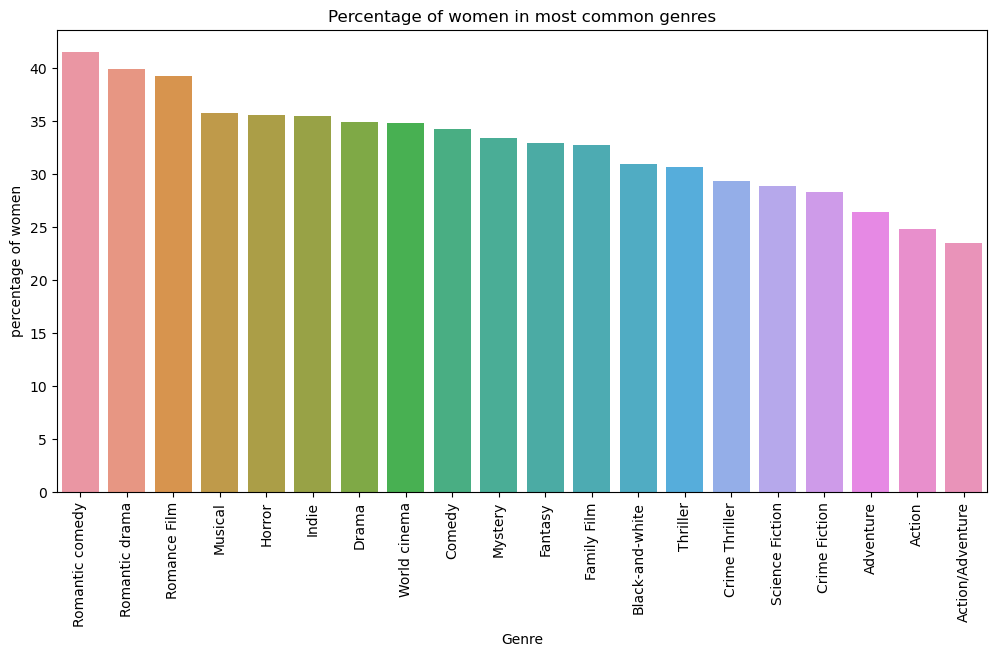

In [69]:
#Making plot
plt.figure(figsize=(12, 6)) 
ax = sns.barplot(x='Genre',y="F_percentage", data=mostcommon)
ax = plt.title("Percentage of women in most common genres")
ax = plt.ylabel("percentage of women")
ax = plt.xticks(rotation=90) 

Next, we want to see if the gender difference in different genres is significant. We will again perform a chi square test, as gender (M/F) as well as genre are categorical.

In [70]:
#Doing a chi suqare test

#Creating contingency table:
df_Genre_FM = gender_counts_2[['Genre', 'F', 'M']]
df_pivoted = df_Genre_FM.pivot_table(index='Genre', values=['F', 'M'])
df_contingency = df_pivoted.T

#Removing columns where M or F is zero because else the chi square test doesn't work.
df_contingency = df_contingency.loc[:, ~(df_contingency == 0).any(axis=0)]

df_contingency
#contingency_table = pd.crosstab(gender_counts_2['Genre'], [gender_counts_2['F'], gender_counts_2['M']])

# Performing chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(df_contingency)


print("Chi-square statistic:", chi2)
print("P-value: {:.2e}".format(p_value))
print("Degrees of freedom:", dof)

Chi-square statistic: 18841.717731398014
P-value: 5.59e-42
Degrees of freedom: 354


We can see that the effect of genre on the gender of the actors playing in it is highly significant, as the p-value is 0.00e+00 (<0.05).

##  8) Female Character Identities in Synopses

Now that we have a better grasp of our data and that it's cleaned let's start to try to answer question 1. The first aspect of this question is do movie summaries use different adjectives for women and men?  What personality traits are typically attributed to them? What implicit meanings are conveyed through adjectives used for women?
For now let's focus on asking ourselves do movie summaries use different adjectives for men and women ?

###  Data preprocessing

The first step we are going to follow is to extract the character names to then be able to change them to the gender of the character. For now we just take the whole character dataset and replace it in the summaries. However this can lead to error for example in the summary used as example the word different  is counted as a male character and is replaced by he while in this context it's not a male character.

In [71]:
dfcharacter.columns

Index(['Wikipedia_ID', 'Freebase_ID', 'Release_date', 'Character_name',
       'Actor_date_of_birth', 'Gender', 'Height', 'Ethnicity', 'Actor_name',
       'Age', 'Freebase_character/actor_map_ID', 'Freebase_character_ID',
       'Freebase_actor_ID'],
      dtype='object')

In [72]:
dfcharacter.iloc[:, [3, 5]].dropna()
df_name_gender = dfcharacter.iloc[:, [3, 5]].dropna()
df_name_gender.columns = ['Name','Gender']
print(df_name_gender.head(5))

                         Name Gender
0                    Akooshay      F
1  Lieutenant Melanie Ballard      F
2         Desolation Williams      M
3          Sgt Jericho Butler      M
4             Bashira Kincaid      F


In [73]:
# build a name dict
name_list = dfcharacter.iloc[:, [3]].dropna()
name_list=name_list.squeeze().tolist()
name_dict = set()
for item in list(name_list):
    names = item.split()
    for name in names:
            name_dict.add(name.lower())
len(name_dict)

68422

In [74]:
# English vocabulary specific to a certain gender
# female_nouns.txt contains common words that are only used to refer to females, like 'mother'
female_words=set()
with open('data/female_nouns.txt', 'r') as file:
    for line in file:
        words = re.split('[^a-zA-Z]', line)
        for word in words:
            if word:
                female_words.add(word.lower())                
                
# male_nouns.txt contains common words that are only used to refer to males, like 'uncle'     
male_words=set()
with open('data/male_nouns.txt', 'r') as file:
    for line in file:
        words = re.split('[^a-zA-Z]', line)
        for word in words:
            if word:
                male_words.add(word.lower())

In [75]:
# Define a list of words representing females/males
# females
df_female_name = df_name_gender[df_name_gender['Gender']=='F']['Name']
female_name_dict = set()
for item in df_female_name:
    names = item.split()
    for name in names:
        # remove the names like 'Alice's father' that can have a negative impact on the result
        if not name.lower() in female_words | male_words:
            if not name.lower().endswith("'s"):
                female_name_dict.add(name.lower())
female_cleaned_list = [re.sub('[^a-zA-Z]', '', s) for s in female_name_dict]


# males
df_male_name = df_name_gender[df_name_gender['Gender']=='M']['Name']
male_name_dict = set()
for item in df_male_name:
    names = item.split()
    for name in names:
        if not name.lower() in female_words | male_words:
            if not name.lower().endswith("'s"):
                male_name_dict.add(name.lower())
male_cleaned_list = [re.sub('[^a-zA-Z]', '', s) for s in male_name_dict]

In [76]:
#some characters have the same family name but different gender,remove the family names
female_name_dict_cleaned = set(female_cleaned_list)
male_name_dict_cleaned = set(male_cleaned_list)

intersection_set = male_name_dict_cleaned & female_name_dict_cleaned
male_name_dict = male_name_dict_cleaned - intersection_set
female_name_dict = female_name_dict_cleaned - intersection_set
cleaned_list = [re.sub('[^a-zA-Z]', '', s) for s in name_dict]
print(len(cleaned_list))
cleaned_list = set(cleaned_list) - intersection_set
print(len(cleaned_list))

68422
53838


In [77]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Testirem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Testirem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Testirem\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [78]:
# data preprocessing
# Set the stopwords
stop_words = set(stopwords.words('english'))

# a list of words representing females/males
female_names_words = female_words | female_name_dict
male_names_words = male_words | male_name_dict

# remove adjs in the name list
adjs_set = set()
with open('data/common_adjs.txt', 'r') as file:
    for line in file:
        word = line.strip().lower()
        adjs_set.add(word)
female_names_words = female_names_words - adjs_set
male_names_words = male_names_words - adjs_set

# function used to tokenize, replace words representing females with 'she' and males with 'he', and remove stopwords
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return ['she' if word in female_names_words else 'he' if word in male_names_words else word for word in text.split() if word not in stop_words]


In [79]:
df_cleaned_summary = dfsummaries["Summary"].apply(lambda x : preprocess_text(x))
documents = list(df_cleaned_summary)

In [80]:
# code to extract adjs(the outcome is stored in data/adjectives.txt, so you can skip this)
# 
female_name_dict = []
with open('data/female_name_dict1.txt', 'r', encoding='utf-8') as file:
    for line in file:
        female_name_dict.append(line.strip())
female_name_dict=set(female_name_dict)
male_name_dict = []
with open('data/male_name_dict1.txt', 'r', encoding='utf-8') as file:
    for line in file:
        male_name_dict.append(line.strip())
male_name_dict=set(male_name_dict)

# Define a list of words representing females/males
female_names_words = female_words | female_name_dict
male_names_words = male_words | male_name_dict
remove_dict=(stop_words | female_names_words | male_names_words)
#from https://www.merriam-webster.com/thesaurus/

def preprocess_text_adj(text):
    # lower the words and remove punctuation
    text_token = word_tokenize(text)
    tagged = pos_tag(text_token)
    adjectives = [word for word, pos in tagged if (pos.startswith('JJ'))]
    text = [word.lower() for word in adjectives if word.isalpha()]
    # tokenize, replace words representing females with 'she' and males with 'he', and remove stopwords.
    return [word for word in text if word not in remove_dict]



documents_adj= list(dfsummaries["Summary"].apply(lambda x : preprocess_text_adj(x)))

In [81]:
adj =[]
for i in documents_adj :
    adj += i

In [82]:
documents_adj = adj

In [83]:
vocabulary=list(set(documents_adj))
word_counts = {word: documents_adj.count(word) for word in vocabulary}
word_count_df = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Count'])
# only use the words appear at least twice
documents_adj=list(word_count_df[word_count_df['Count']>1]['Word'])

In [84]:
word_count_df.sort_values(by="Count", ascending = False).head(20)

,Word,Count
11659,young,12155
5282,new,11888
8998,first,9725
2605,old,8425
2455,local,6436
14701,dead,6366
5063,last,6158
4204,several,5365
10144,small,4508
5260,former,4325


In [98]:
# remove some words in case of incorrect classification
lines = []

# file from https://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/
with open('data/female name.txt', 'r', encoding='utf-8') as file:
    for line in file:
        line=line.lower()
        lines.append(line.strip())
documents_adj = set(documents_adj)-set(lines)

lines = []
with open('data/male name.txt', 'r', encoding='utf-8') as file:
    for line in file:
        line=line.lower()
        lines.append(line.strip())
documents_adj = set(documents_adj)-set(lines)


print(len(documents_adj))
other_common_words = set(['child', 'orphan', 'baby', 'girls', 'lover', 'mute','child', 'orphan', 'bride', 
                          'baby', 'girls', 'lover', 'mute', 'housekeeper', 'cousin', 'neighbour', 'parent', 
                          'sibling', 'pregnant', 'housewife', 'relative', 'servant', 'waif', 'grandson', 
                          'stranger', 'courtesan', 'servant','cousin', 'neighbour', 'parent', 'sibling', 
                          'housewife','nurse', 'stepsister', 'housekeeper','grandson','servant','grandchildren',
                          'relatives', 'uncles', 'orphans', 'childbirth', 'scoundrel', 'foreigner', 'stepfamily', 
                          'tuberculosis', 'mallaya', 'triplet', 'grandchildren', 'outcast', 'neighbours', 'huanhuan', 
                          'lakshmiammal', 'jaipal', 'himal', 'pasarian', 'leukemia'])
documents_adj = set(documents_adj)-set(other_common_words)

8672


In [99]:
# save data
with open('data/adjectives.txt', 'w', encoding='utf-8') as file:
    for item in documents_adj:
        file.write(item + '\n')

In [100]:
# load the data adjectives.txt (extracted from the text)
adjectives = []
with open('data/adjectives.txt', 'r', encoding='utf-8') as file:
    for line in file:
        adjectives.append(line.strip())

In [101]:
# train the word2vec model
model = Word2Vec(documents, vector_size=100, window=5, min_count=1, workers=4)

# save the model
model.save("word2vec.model")

In [102]:
# apply the model
model = Word2Vec.load("word2vec.model")
adjectives = [word for word in adjectives if word in model.wv.key_to_index]
adj_vectors = [model.wv[word] for word in adjectives]
vector_she = model.wv['she']
vector_he = model.wv['he']

In [103]:
# example: lovely
similarity = cosine_similarity(vector_she.reshape(1,-1), model.wv['lovely'].reshape(1,-1))
print(f'similarity between female and lovely: {similarity}')
similarity = cosine_similarity(vector_he.reshape(1,-1), model.wv['lovely'].reshape(1,-1))
print(f'similarity between male and lovely: {similarity}')

similarity between female and lovely: [[0.45308715]]
similarity between male and lovely: [[0.17489536]]


In [104]:
female_reference_vector = vector_she.reshape(1, -1)
female_similarities = [cosine_similarity(female_reference_vector, vec.reshape(1, -1))[0][0] for vec in adj_vectors]
male_reference_vector = vector_he.reshape(1, -1)
male_similarities = [cosine_similarity(male_reference_vector, vec.reshape(1, -1))[0][0] for vec in adj_vectors]

In [128]:
similaritie = pd.DataFrame({'Female':female_similarities,'Male':male_similarities})
similaritie.index=adjectives
similaritie2= similaritie.sort_values(by=['Male'], ascending= False)
print(similaritie2)

               Female      Male
yogi         0.476256  0.553366
everybody    0.585360  0.534057
right        0.408508  0.532509
longer       0.603169  0.525210
stop         0.389133  0.523057
...               ...       ...
maladjusted -0.177298 -0.202231
starring    -0.182722 -0.212522
amerasian   -0.134432 -0.222839
directed    -0.212033 -0.229321
de          -0.262451 -0.354575

[8647 rows x 2 columns]


In [119]:
similarity_diff=similaritie['Female']-similaritie['Male']
top_100_female_adj = similarity_diff.sort_values(ascending=False).head(100).index
print(top_100_female_adj)
top_100_male_adj = similarity_diff.sort_values(ascending=True).head(100).index
print(top_100_male_adj)

Index(['unhappy', 'loving', 'beautiful', 'lovely', 'shy', 'deeply', 'somewhat',
       'fiancé', 'lonely', 'fond', 'fiancée', 'attracted', 'insecure',
       'lifestyle', 'divorced', 'overprotective', 'charming', 'sweetheart',
       'desire', 'passionate', 'intimate', 'promiscuous', 'smitten', 'grown',
       'neighbor', 'caring', 'younger', 'older', 'twin', 'neglected', 'affair',
       'shared', 'unmarried', 'neglectful', 'deaf', 'jealousy', 'intrigued',
       'engaged', 'orgiastic', 'mancunian', 'cheerful', 'behaviour', 'seduced',
       'disturbed', 'socialite', 'introverted', 'spoiled', 'overbearing',
       'emotional', 'unwholesome', 'dreams', 'adopted', 'loved', 'courtship',
       'married', 'repressed', 'émilie', 'teenage', 'carefree', 'domineering',
       'metaphoric', 'aloof', 'strangely', 'loneliness', 'childless', 'pretty',
       'vivacious', 'anjali', 'unwed', 'quarrelsome', 'widower', 'insensitive',
       'openly', 'eldest', 'sexual', 'infatuated', 'delighted', 'sn

(-0.5, 399.5, 199.5, -0.5)

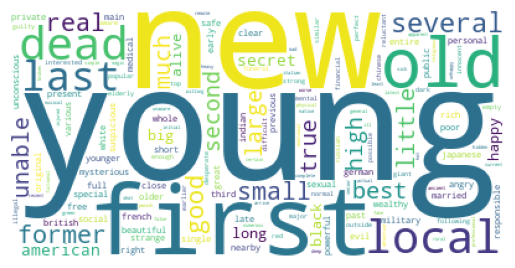

In [477]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(background_color='white').generate_from_frequencies(word_counts)

plt.imshow(wc)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

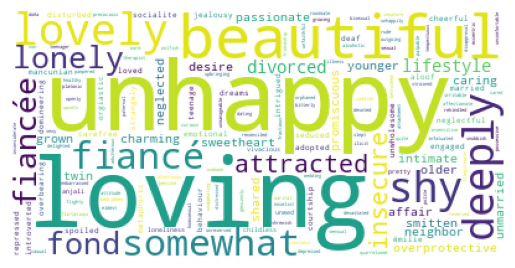

In [478]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(background_color='white').generate_from_frequencies(similarity_diff)

plt.imshow(wc)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

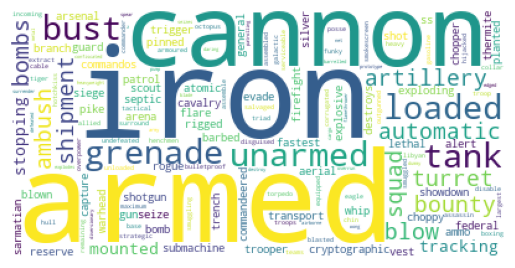

In [644]:
wc2 = WordCloud(background_color='white').generate_from_frequencies(-similarity_diff)
plt.imshow(wc2)
plt.axis('off')

,Wikipedia_ID,Freebase_ID,Movie_name,Release_date,box_office_revenue,runtime,languages,countries,genres,test,Summary,Summary_Length


In [717]:
movie_summary_char_merged = summary_and_movie[['Freebase_ID','test','Summary']].merge(character_with_name [['Character_name','Freebase_ID','Gender']] ,on="Freebase_ID",how ='right').dropna()
movie_summary_char_merged['test'].unique()

array(['2001', '2005', '1989', '2009', '1986', '1939', '1987', '1994',
       '1975', '1952', '2012', '1934', '2007', '1996', '2008', '1979',
       '2010', '1954', '1997', '1977', 'nan', '1998', '1971', '2011',
       '2003', '1978', '1950', '1953', '1995', '1993', '2000', '2004',
       '2002', '1942', '1991', '1958', '1949', '1933', '2006', '1931',
       '1941', '1959', '1983', '1924', '1980', '1984', '1988', '1968',
       '1947', '1990', '1981', '1982', '1999', '1940', '1956', '1992',
       '1985', '1969', '1945', '1943', '1948', '1927', '1976', '1961',
       '1970', '1964', '1955', '1944', '1965', '1963', '1974', '1966',
       '1935', '1957', '1937', '1928', '2013', '1972', '1929', '1932',
       '1951', '1936', '1962', '1960', '1946', '1967', '1938', '1921',
       '1973', '1930', '1913', '1926', '1916', '1920', '1910', '1919',
       '1925', '1915', '1923', '1010', '1918', '1914', '1908', '1912',
       '1922', '1917', '1896', '2014', '1907', '1911', '1901', '1902',
       

In [713]:
#counting the number of character names occurence in summaries
def count_characters(row): 
    char_count = row['Character_name'] 
    summary_search = row['Summary'] 
    return summary_search.count(char_count)

#finding protagonists (occurence of character name more than once in summary)

movie_summary_char_merged.loc[:,'Count_of_Char']= movie_summary_char_merged.apply(count_characters,axis=1)
movie_summary_char_merged = movie_summary_char_merged [movie_summary_char_merged ['Count_of_Char']>1]

#filtering for female and male protagonist characters

#df['Fee'] = df['Fee'].astype('int')
movie_summary_char_merged.loc[:,'test']=pd.to_numeric(movie_summary_char_merged['test'],errors='coerce').fillna(0).astype('int')
movie_summary_char_merged.loc[:,'period'] = pd.cut(movie_summary_char_merged['test'], bins=range(1900, 2030, 10))
movie_summary_char_merged.loc[:,'period']=movie_summary_char_merged.loc[:,'period'].astype('str')

#f_movie_summary_char_merged=movie_summary_char_merged [movie_summary_char_merged['Character_name'].isin(df_female_name)]

#m_movie_summary_char_merged=movie_summary_char_merged [~movie_summary_char_merged['Character_name'].isin(df_female_name)]

C:\Users\Testirem\AppData\Local\Temp\ipykernel_14204\160963540.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_summary_char_merged.loc[:,'period'] = pd.cut(movie_summary_char_merged['test'], bins=range(1900, 2030, 10))


In [720]:
movie_summary_char_merged_grouped = movie_summary_char_merged.groupby(['period','Gender']).sum('Count_of_Char')
#.apply(lambda x: 100 * (x.Count_of_Char / x.Count_of_Char.sum()))
#movie_summary_char_merged_grouped = movie_summary_char_merged_grouped[movie_summary_char_merged_grouped['Gender'].notna()]

movie_summary_char_merged_grouped['Percentage'] = movie_summary_char_merged_grouped.groupby('period')['Count_of_Char'].transform(lambda x: (x / x.sum()) * 100)

#movie_summary_char_merged_grouped = movie_summary_char_merged.groupby(['period','Gender']).sum('Count_of_Char')
#movie_summary_char_merged_grouped['percentage'] = movie_summary_char_merged.groupby('period').Count_of_Char.apply(lambda x:  (x / x.sum()) * 100)

movie_summary_char_merged_grouped


KeyError: 'period'

In [707]:
movie_summary_char_merged[movie_summary_char_merged['period']=='nan']['test']

1488      0
2490      0
4980      0
5091      0
5539      0
         ..
138435    0
140488    0
141401    0
141402    0
141880    0
Name: test, Length: 190, dtype: object

In [719]:
plt.figure(figsize=(12, 6)) 
ax = sns.barplot(x='period',y="Percentage", data=movie_summary_char_merged_grouped)
ax = plt.title("Evolution of the number of men words mentioned in summaries")
ax = plt.ylabel("the number of men words mentioned in summaries")
ax = plt.xticks(rotation=90)

ValueError: Could not interpret input 'period'

<Figure size 1200x600 with 0 Axes>

In [ ]:
movie_summary_char_merged_grouped 

Text(0.5, 0, 'Periods')

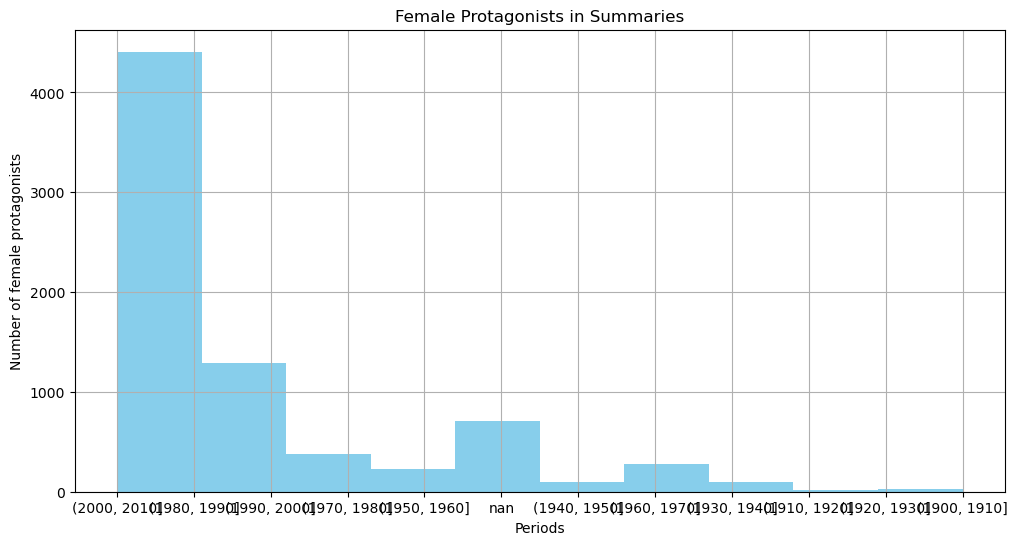

In [691]:
#looking for change in years
#f_movie_summary_char_merged=movie_summary_char_merged

plt.figure(figsize=(12, 6)) 
movie_summary_char_merged[movie_summary_char_merged['Gender']=='F']['period'].dropna().hist(color = "skyblue")
plt.title("Female Protagonists in Summaries")
plt.ylabel("Number of female protagonists")
plt.xlabel("Periods")

Text(0.5, 0, 'Periods')

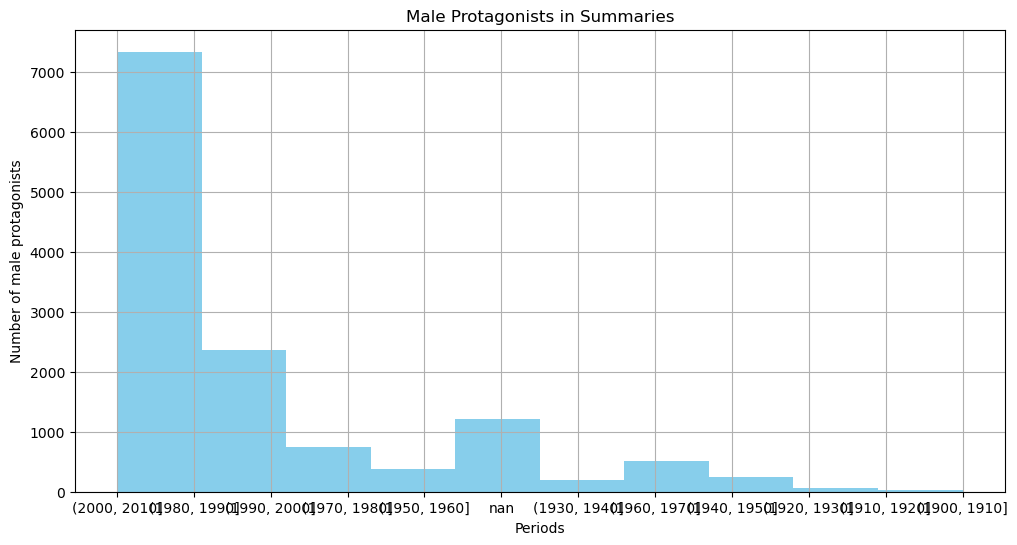

In [538]:
#looking for change of men protagonists in years

plt.figure(figsize=(12, 6)) 
movie_summary_char_merged[movie_summary_char_merged['Gender']=='M']['period'].hist(color = "skyblue")
plt.title("Frequency of Summary length")
plt.ylabel("Number of female protagonists")
plt.xlabel("Periods")

In [498]:
def count_females(row): 
    count_female_words = 'she' 
    summary_search = row['Summary'] 
    return summary_search.count(count_female_words)

def count_males(row): 
    count_male_words = 'he' 
    summary_search = row['Summary'] 
    return summary_search.count(count_male_words)

In [499]:
f_movie_summary_char_merged ['Count_of_Female_Word']= f_movie_summary_char_merged.apply(count_females,axis=1)
m_movie_summary_char_merged ['Count_of_Male_Word']= m_movie_summary_char_merged.apply(count_males,axis=1)

f_movie_summary_char_merged ['Count_of_Female_Word']=f_movie_summary_char_merged ['Count_of_Female_Word']+f_movie_summary_char_merged ['Count_of_Char']
m_movie_summary_char_merged ['Count_of_Male_Word']=m_movie_summary_char_merged ['Count_of_Male_Word']+m_movie_summary_char_merged ['Count_of_Char']

C:\Users\Testirem\AppData\Local\Temp\ipykernel_14204\1793449174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_movie_summary_char_merged ['Count_of_Female_Word']= f_movie_summary_char_merged.apply(count_females,axis=1)
C:\Users\Testirem\AppData\Local\Temp\ipykernel_14204\1793449174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_movie_summary_char_merged ['Count_of_Male_Word']= m_movie_summary_char_merged.apply(count_males,axis=1)
C:\Users\Testirem\AppData\Local\Temp\ipykernel_14204\1793449174.

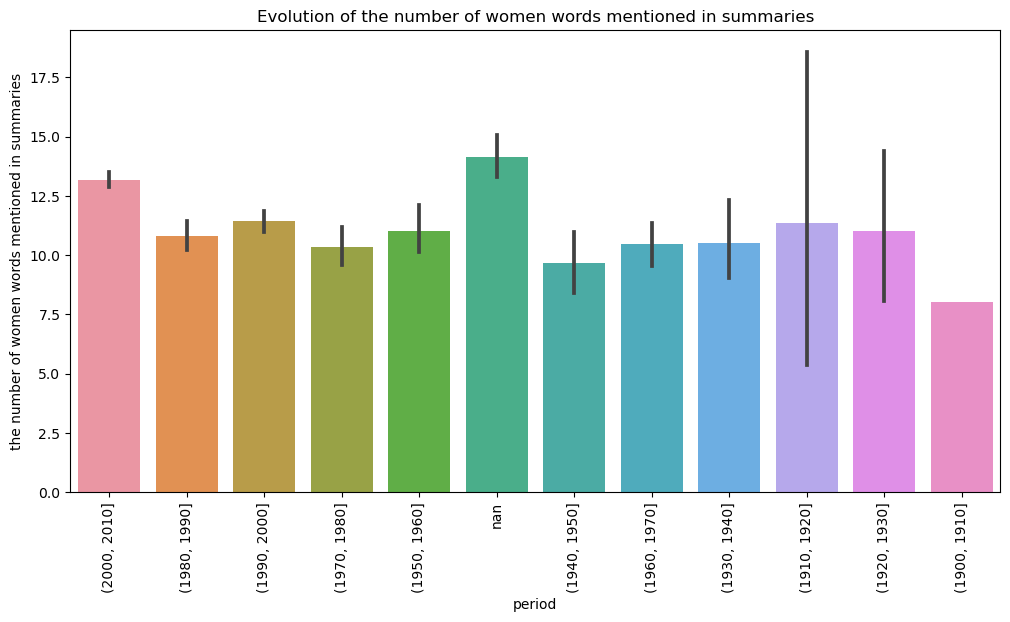

In [500]:
#Making plot
plt.figure(figsize=(12, 6)) 
ax = sns.barplot(x='period',y="Count_of_Female_Word", data=f_movie_summary_char_merged)
ax = plt.title("Evolution of the number of women words mentioned in summaries")
ax = plt.ylabel("the number of women words mentioned in summaries")
ax = plt.xticks(rotation=90)

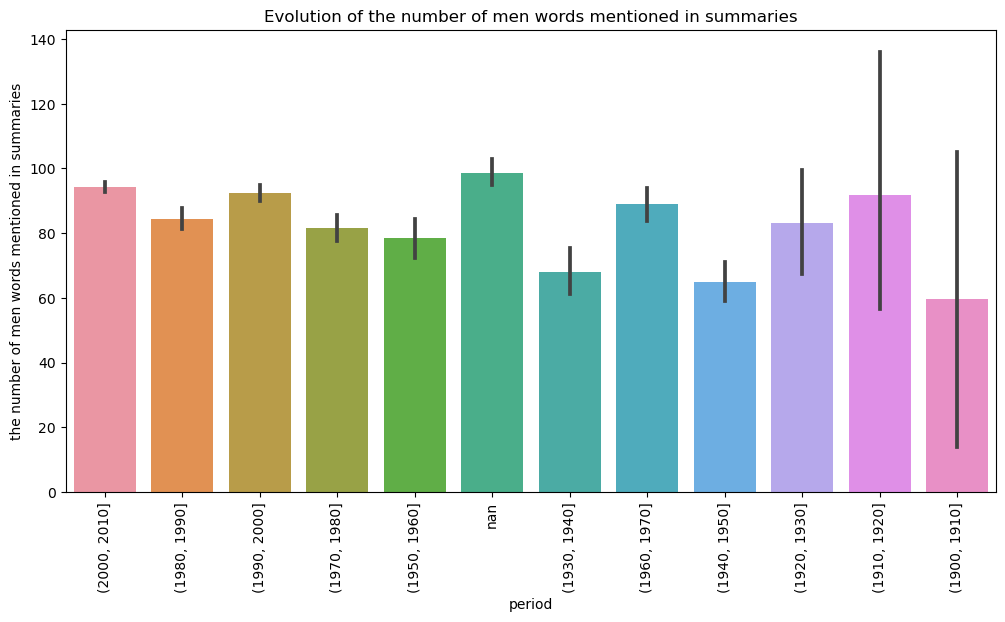

In [501]:
#Making plot
plt.figure(figsize=(12, 6)) 
ax = sns.barplot(x='period',y="Count_of_Male_Word", data=m_movie_summary_char_merged)
ax = plt.title("Evolution of the number of men words mentioned in summaries")
ax = plt.ylabel("the number of men words mentioned in summaries")
ax = plt.xticks(rotation=90)

In [633]:
p1_movie_summary_char_merged = movie_summary_char_merged [movie_summary_char_merged ['period']=='(2000, 2010]']

In [634]:
df_cleaned_summary_2 = p1_movie_summary_char_merged["Summary"].apply(lambda x : preprocess_text(x))
documents_2 = list(df_cleaned_summary_2)
documents_adj_2= list(p1_movie_summary_char_merged["Summary"].apply(lambda x : preprocess_text_adj(x)))


In [635]:
adj_2 =[]
for i in documents_adj_2 :
    adj_2 += i

In [636]:
documents_adj_2 = adj_2

In [637]:
vocabulary_2=list(set(documents_adj_2))
word_counts_2 = {word: documents_adj_2.count(word) for word in vocabulary_2}
word_count_df_2 = pd.DataFrame(list(word_counts_2.items()), columns=['Word', 'Count'])
# only use the words appear at least twice
documents_adj_2=list(word_count_df_2[word_count_df_2['Count']>1]['Word'])

In [638]:
word_count_df_2.sort_values(by="Count", ascending = False).head(20)

,Word,Count
2094,new,5563
3538,first,4593
4639,young,3905
1032,old,3393
5877,dead,3218
2007,last,2988
973,local,2551
1660,several,2462
2927,real,2147
4410,best,1970
